In [1]:
import haversine as hs
from haversine import Unit
from scan_area import ScanArea
import math
import matplotlib.pyplot as plt
import numpy as np
import copy
from tqdm import tqdm
from shapely.ops import linemerge, unary_union, polygonize
from shapely.geometry import LineString, Polygon, Point
from matplotlib import pyplot as plt
import geopandas as gpd


In [2]:
coordinates2 =[[41.08615,29.03986],[41.08550,29.03955],[41.08490,29.04151],[41.08581,29.04182],[41.08653,29.04063]]
coordinates=[[41.085275, 29.040304], [41.085803, 29.040478], [41.085679, 29.041173], [41.085148, 29.040999], [41.085275, 29.040304]]

In [3]:
# # print(coordinates2)
# arr = np.array(coordinates2)
# y_mean = np.mean(arr[:,1])
# arr_up = np.sort(arr[arr[:,1]>y_mean],axis=0)
# arr_down = np.sort(arr[arr[:,1]<y_mean],axis=0)
# print(len(arr_down))
# arr_down_reversed = []
# for i in range(len(arr_down)-1,-1,-1):
#     arr_down_reversed.append(arr_down[i])
# arr_down_reversed = np.array(arr_down_reversed)
# group1 = []
# concat_arr =np.concatenate([arr_up,arr_down_reversed])

# for i,p in enumerate(concat_arr):
#     print(p[0],p[1])
#     plt.scatter(p[0],p[1],label=f"{i}")
# plt.legend()
# plt.show()

In [4]:
nodes = []
for coord in coordinates:
    nodes.append((coord[0], coord[1]))


route_angle = (math.pi * 0 / 180)
rotated_route_angle = (math.pi * 20 / 180)
polygon = ScanArea(coords=nodes)
optimal_route_nodes, rotated_route_nodes = polygon.create_route(40, 0.8, route_angle, rotated_route_angle)
longest = polygon.find_the_longest_edge()
longest_point1 = longest.coords[0]
longest_point2 = longest.coords[1]


In [5]:
def get_route(coordinates):
    nodes = []
    for coord in coordinates:
        nodes.append((coord[0], coord[1]))
    route_angle = (math.pi * 0 / 180)
    rotated_route_angle = (math.pi * 20 / 180)
    polygon = ScanArea(coords=nodes)
    optimal_route_nodes, rotated_route_nodes = polygon.create_route(40, 0.8, route_angle, rotated_route_angle,0)

    return(optimal_route_nodes)

In [6]:
def get_edges(coords):
    edges = []
    for i in range(len(coords) - 1):
        edges.append(LineString([coords[i], coords[i + 1]]))
    edges.append(LineString([coords[-1], coords[0]]))  # Closing the polygon
    return edges

In [7]:
def est_duration(route_nodes):
    node_count = len(route_nodes)
    len_lines = []
    for i in range(len(route_nodes)-1):
        if i%2 == 0:
            temp_node1 = route_nodes[i]
            temp_node2 = route_nodes[i+1]
            len_lines.append(hs.haversine(temp_node1, temp_node2, unit=Unit.METERS))
    # print(len_lines)
    distance = sum(len_lines)
    # print(node_count, distance)
    est_time = node_count * 4 + (distance/5)
    return est_time

# est_duration(rotated_route_nodes)

In [8]:
def prerpocess_groups(group):
    group1 = copy.deepcopy(group)
    arr_gr1 = np.array(group1)
    mean_y1 = np.mean(arr_gr1[:,1])
    print(f"mean_y : {mean_y1}")
    arr_gr1_up = np.sort(arr_gr1[arr_gr1[:,1]>mean_y1],axis=0)
    arr_gr1_down = np.sort(arr_gr1[arr_gr1[:,1]<mean_y1],axis=0)
    arr_down_reversed = []
    
    print(f"arr_gr1_up : {arr_gr1_up}")
    
    for i in range(len(arr_gr1_down)-1,-1,-1):
        arr_down_reversed.append(arr_gr1_down[i])
    arr_down_reversed = np.array(arr_down_reversed)
    print(f"arr_gr1_down : {arr_down_reversed}")
    
    concat_arr_g =np.concatenate([arr_gr1_up,arr_down_reversed])
    
    print(f"concat : {concat_arr_g}")
    np.append(concat_arr_g,concat_arr_g[0])
    print(f"return : {concat_arr_g}")
    return concat_arr

In [9]:
def cut_polygon_by_line(polygon, line):
    merged = linemerge([polygon.boundary, line])
    borders = unary_union(merged)
    polygons = polygonize(borders)
    return list(polygons)

def plot(shapely_objects, figure_path='fig.png'):
    boundary = gpd.GeoSeries(shapely_objects)
    boundary.plot(color=['red', 'green', 'blue', 'yellow', 'yellow','red','red'])
    plt.show()

In [34]:
def find_midpoint(coordinates,angle_offset,m = 1,rec_quit= False):
    nodes = []
    for coord in coordinates:
        nodes.append((coord[0], coord[1]))
    
    polygon = ScanArea(coords=nodes)
    # plot(polygon.polygon)
    longest = polygon.find_the_longest_edge()
    
    max_len = 0
    max_len_idx = 0
    min_x = 1000
    min_y = 1000
    max_x = -1000
    max_y = -1000
    for  coord in coordinates:
        min_x = coord[0] if coord[0] < min_x else min_x
        max_x = coord[0] if coord[0] > max_x else max_x
        min_y = coord[1] if coord[1] < min_y else min_y
        max_y = coord[1] if coord[1] > max_y else max_y

    if m > 0:
        start_point = [min_x, min_y]
        end_point = [max_x, max_y]
    else:
        start_point = [min_x,max_y]
        end_point = [max_x,min_y]
    m1 = (longest.coords[1][1]-longest.coords[0][1])/(longest.coords[1][0]-longest.coords[0][0])
    angle = math.degrees(math.atan(m1)) + angle_offset
    m1 = math.tan(math.radians(angle))
    while_check = True
    counter = 0
    while while_check:
        counter+=1
        if counter >= 30:
            if rec_quit:
                # plot([polygons[0],polygons[1],check_line])
                return 0,10000
            return find_midpoint(coordinates,angle_offset,-m,True)
        check_line = LineString([start_point,end_point])
        mid_point = ((start_point[0]+end_point[0])/2,(start_point[1]+end_point[1])/2)
        mid_point_extension0 = (mid_point[0]-0.003,mid_point[1]-0.003*m1)
        mid_point_extension1 = (mid_point[0]+0.003,mid_point[1]+m1*0.003)

        mid_line = LineString([[mid_point_extension0[0],mid_point_extension0[1]],[mid_point_extension1[0],mid_point_extension1[1]]])
        polygons = cut_polygon_by_line(polygon.polygon,mid_line)
        if len(polygons) == 1:
            if smaller:
                end_point = mid_point
                smaller = False
            else:
                start_point = mid_point
                smaller = True
            continue

            
        p1 = polygons[0]
        p2 = polygons[1]

        coor1= list(p1.exterior.coords)
        coor2= list(p2.exterior.coords)
        r1 = get_route(coor1)
        r2 = get_route(coor2)
        est1 = est_duration(r1)
        est2 = est_duration(r2)
        if abs(est2 - est1) < 4:
            while_check = False
            print(f"estimateds {angle_offset}: {est1} , {est2}")
            # plot(polygons)
            break
        if est2 < est1:
            if p1.centroid.x > p2.centroid.x:
                start_point = mid_point
                smaller = True
            else:
                end_point = mid_point
                smaller = False
        else:
            if p1.centroid.x > p2.centroid.x:
                end_point = mid_point
                smaller = False
            else:
                start_point = mid_point
                smaller = True
        # print(f"estimateds {counter}: {est1} , {est2}")
        # plot([polygons[0],polygons[1],check_line])
    # plot(polygons)
    return polygons, min(est1,est2)
# polygons = find_midpoint(coordinates2,angle_offset = 0)


In [78]:
min_time = 10000
min_idx = 3000
for i in range(-90,90,1):
    polygon,time1 = find_midpoint(coordinates2,i)
    polygon,time2 = find_midpoint(coordinates2,i+20)
    min_idx = i if time1+time2 < min_time else min_idx
    min_time = time1+time2 if time1+time2 < min_time else min_time
    
    
print(min_time, min_idx)

estimateds -90: 300.7410807883923 , 304.65286664372974
estimateds -70: 279.6990005704639 , 277.7460873072563
estimateds -89: 299.94678368746884 , 298.32622275726897
estimateds -69: 277.8189115802269 , 276.0050653356759
estimateds -88: 297.1135551984429 , 298.0766358836222
estimateds -68: 275.9036280994165 , 274.4053936380827
estimateds -87: 296.4863816443451 , 296.3775701040005
estimateds -67: 274.2411467070951 , 272.9331608509055
estimateds -86: 288.4712634729307 , 285.07768086949665
estimateds -66: 272.7845427904914 , 271.5771242673479
estimateds -85: 289.04293616340067 , 292.4305575002617
estimateds -65: 272.8145763487754 , 269.2102098765136
estimateds -84: 289.47861281747885 , 292.2581233107386
estimateds -64: 264.1646952841134 , 268.09389422055403
estimateds -83: 290.22537523491764 , 290.9747172125679
estimateds -63: 264.5720033107706 , 265.06566015302354
estimateds -82: 290.527321801521 , 291.05713006088695
estimateds -62: 263.5000132185949 , 263.4433520212914
estimateds -81: 289

In [79]:
polygons1 , _ = find_midpoint(coordinates2,angle_offset = min_idx)
polygons2 , _ = find_midpoint(coordinates2,angle_offset = min_idx+20)

estimateds -24: 221.05785071932115 , 224.47935462300103
estimateds -4: 208.58003132601948 , 204.58828046071216


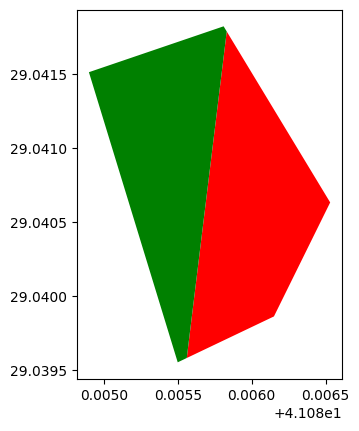

In [80]:
plot(polygons1)

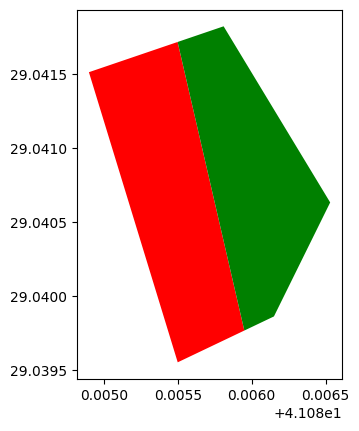

In [81]:
plot(polygons2)

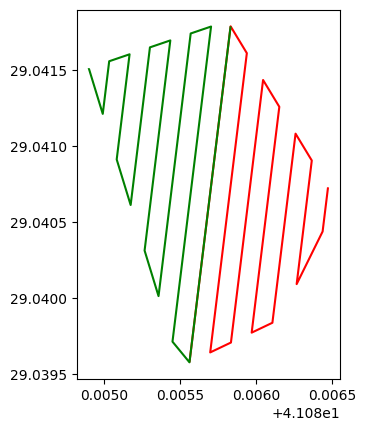

In [82]:
p1 = polygons1[0]
p2 = polygons1[1]

coor1= list(p1.exterior.coords)
coor2= list(p2.exterior.coords)
r1 = get_route(coor1)
r2 = get_route(coor2)
a = LineString(r1)
b = LineString(r2)
plot([a,b])

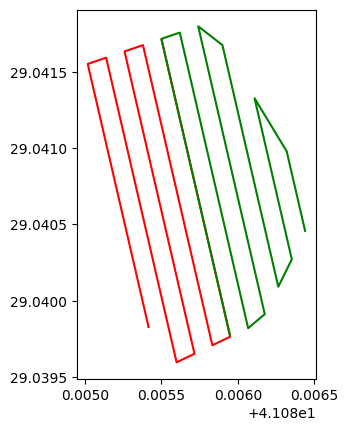

In [83]:
p1 = polygons2[0]
p2 = polygons2[1]
coor1= list(p1.exterior.coords)
coor2= list(p2.exterior.coords)
r1 = get_route(coor1)
r2 = get_route(coor2)
a = LineString(r1)
b = LineString(r2)
plot([a,b])

In [14]:
coor2

[(41.085842137873286, 29.039713173447257),
 (41.0855918381748, 29.041745681136472),
 (41.08581, 29.04182),
 (41.08653, 29.04063),
 (41.08615, 29.03986),
 (41.085842137873286, 29.039713173447257)]

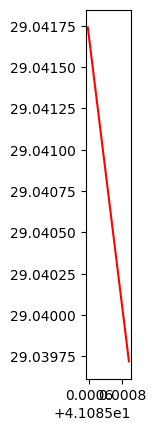

In [15]:
edges2 = get_edges(coor1)
plot(edges2[0])